In [104]:
import numpy as np
import matplotlib as plt
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

Load MNIST

In [16]:
mnist = fetch_openml('mnist_784', version=1, parser='auto')
X, y = mnist["data"], mnist["target"].astype(np.int64)

X = X.to_numpy() if hasattr(X, 'to_numpy') else X
y = y.to_numpy() if hasattr(y, 'to_numpy') else y

X = X / 255.0 #normalizing data

Test & Train Partitioning

In [20]:
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.99, random_state=42)

for train_index, test_index in strat_split.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

# Check if there are at least 10 samples of each label in the train set
unique, counts = np.unique(y_train, return_counts=True)
label_counts = dict(zip(unique, counts))
for label, count in label_counts.items():
    print(f"Label {label}: {count} samples")

Label 0: 69 samples
Label 1: 79 samples
Label 2: 70 samples
Label 3: 71 samples
Label 4: 68 samples
Label 5: 63 samples
Label 6: 69 samples
Label 7: 73 samples
Label 8: 68 samples
Label 9: 70 samples


Print data from data set

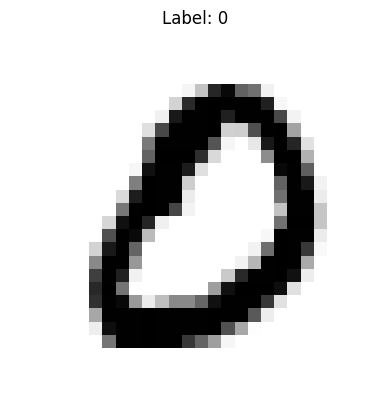

In [95]:
import matplotlib.pyplot as plt
def display_sample(X, y, index):
    image = X[index].reshape(28, 28) 
    label = y[index]
    plt.imshow(image, cmap='gray_r')
    plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()

index = np.random.randint(0, len(X_train))
display_sample(X_train, y_train, index)

Kernels

In [101]:
param_grid_linear = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
param_grid_poly = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'degree': [2], 'coef0': [0, 1, 2, 3]}
param_grid_rbf = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

svm_linear = SVC(kernel='linear')
svm_poly = SVC(kernel='poly')
svm_rbf = SVC(kernel='rbf')

grid_search_linear = GridSearchCV(svm_linear, param_grid_linear, cv=5, scoring='accuracy')
grid_search_poly = GridSearchCV(svm_poly, param_grid_poly, cv=5, scoring='accuracy')
grid_search_rbf = GridSearchCV(svm_rbf, param_grid_rbf, cv=5, scoring='accuracy')

Train

In [102]:
grid_search_linear.fit(X_train, y_train)
grid_search_poly.fit(X_train, y_train)
grid_search_rbf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
             scoring='accuracy')

Scores & Best parameters

In [105]:
best_params_linear = grid_search_linear.best_params_
best_score_linear = grid_search_linear.best_score_

best_params_poly = grid_search_poly.best_params_
best_score_poly = grid_search_poly.best_score_

best_params_rbf = grid_search_rbf.best_params_
best_score_rbf = grid_search_rbf.best_score_


best_svm_linear = grid_search_linear.best_estimator_
best_svm_poly = grid_search_poly.best_estimator_
best_svm_rbf = grid_search_rbf.best_estimator_

y_test_pred_linear = best_svm_linear.predict(X_test)
y_test_pred_poly = best_svm_poly.predict(X_test)
y_test_pred_rbf = best_svm_rbf.predict(X_test)

test_score_linear = accuracy_score(y_test, y_test_pred_linear)
test_score_poly = accuracy_score(y_test, y_test_pred_poly)
test_score_rbf = accuracy_score(y_test, y_test_pred_rbf)

print(f"Linear Kernel - Best Params: {best_params_linear}, CV Score: {best_score_linear}, Test Score: {test_score_linear}")
print(f"Polynomial Kernel (degree 2) - Best Params: {best_params_poly}, CV Score: {best_score_poly}, Test Score: {test_score_poly}")
print(f"RBF Kernel - Best Params: {best_params_rbf}, CV Score: {best_score_rbf}, Test Score: {test_score_rbf}")

# Determine which kernel has the best score
best_kernel = "Linear" if test_score_linear > test_score_poly and test_score_linear > test_score_rbf else \
              "Polynomial" if test_score_poly > test_score_rbf else "RBF"

best_params = best_params_linear if best_kernel == "Linear" else \
              best_params_poly if best_kernel == "Polynomial" else best_params_rbf

best_score = test_score_linear if best_kernel == "Linear" else \
             test_score_poly if best_kernel == "Polynomial" else test_score_rbf

best_svm = best_svm_linear if best_kernel == "Linear" else \
             best_svm_poly if best_kernel == "Polynomial" else best_svm_rbf

print(f"The best kernel is: {best_kernel} with parameters: {best_params} and a test score of: {best_score}")

Linear Kernel - Best Params: {'C': 0.01}, CV Score: 0.8557142857142856, Test Score: 0.8773737373737374
Polynomial Kernel (degree 2) - Best Params: {'C': 10, 'coef0': 0, 'degree': 2}, CV Score: 0.8857142857142858, Test Score: 0.8988600288600289
RBF Kernel - Best Params: {'C': 10, 'gamma': 0.01}, CV Score: 0.8942857142857144, Test Score: 0.9131168831168831
The best kernel is: RBF with parameters: {'C': 10, 'gamma': 0.01} and a test score of: 0.9131168831168831


Train best kernel on dataset

In [106]:
best_svm.fit(X_train, y_train)

y_train_pred = best_svm.predict(X_train)

train_error = 1 - accuracy_score(y_train, y_train_pred)

y_test_pred_svm = best_svm.predict(X_test)

test_error = 1 - accuracy_score(y_test, y_test_pred_svm)

print(f"Training Error: {train_error:.4f}")
print(f"Test Error: {test_error:.4f}")

Training Error: 0.0000
Test Error: 0.0869


Logistic Regression

In [112]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

y_test_pred_logreg = log_reg.predict(X_test)

test_error_logreg = 1 - accuracy_score(y_test, y_test_pred_logreg)

print(f"Test Error (Logistic Regression): {test_error_logreg:.4f}")

Test Error (Logistic Regression): 0.1447


Best SVM vs Logistic Regression

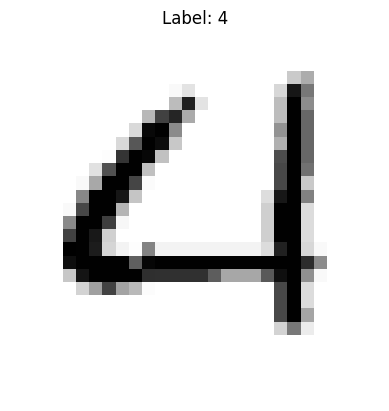

In [117]:
misclassified_indices_logreg = np.where(y_test != y_test_pred_logreg)[0]

correctly_classified_indices_svm = np.where(y_test == y_test_pred_svm)[0]

misclassified_digit_index = None
for idx in misclassified_indices_logreg:
    if idx in correctly_classified_indices_svm:
        misclassified_digit_index = idx
        break

if misclassified_digit_index is not None:
    display_sample(X_test, y_test, misclassified_digit_index)
else:
    print("No digit misclassified by Logistic Regression and correctly classified by SVM found.")